In [2]:
import sys
sys.path.append('../')
import config
from collections import OrderedDict, defaultdict
from models import *
from models.CharTransE import *
import numpy as np
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import csv
import torch

In [3]:
con = config.Config()
#con.set_in_path("../benchmarks/tim_minikb/seed1/")
#con.set_result_dir("../result/tuneEpochs/")
#con.set_result_dir("../result/margin2.0/")
#con.set_result_dir("../result/l2norm/")

#con.set_in_path("../benchmarks/newData/seed1/")
#con.set_result_dir("../result/newData/")

#con.set_in_path('../benchmarks/newData/seed2/')
#con.set_result_dir('../result/newData_seed2/')

#con.set_in_path('../benchmarks/triplesNew/seed1/')
#con.set_result_dir('../result/triplesNew_seed1/')

#con.set_in_path('../benchmarks/triplesNew/moreTriples/')
#con.set_result_dir('../result/triplesNew_moreTriples/')

con.set_in_path('../benchmarks/corefData/seed1/')
con.set_result_dir('../result/corefData_seed1/')

con.init()

In [4]:
ent2id = OrderedDict()
id2ent = OrderedDict()
with open( con.in_path + 'entity2id.txt') as nf:
    lines = [line.split('\t') for line in nf.readlines()[1:]]
    ent2id = {line[0].strip():int(line[1]) for line in lines}
    id2ent = {int(line[1]):line[0] for line in lines}
    
#name_ids = [id_ for ent, id_ in ent2id.items() if not ent.startswith('http')]
#ent_ids = [id_ for ent, id_ in ent2id.items() if 'entities' in ent]
ent_ids = [id_ for ent, id_ in ent2id.items()]
    
             
trip_dict = defaultdict(list) #groups entries of the same head together{head:[list of entries with this head]}
with open(con.in_path + 'train2id.txt') as rf:
    triples = [[int(el) for el in line.split(' ')] for line in rf.readlines()[1:]]
    for trip in triples:
        trip_dict[trip[0]] += [trip]

In [5]:
cte = CharTransE(con)
cte.load_state_dict(torch.load(con.result_dir +  'CharTransE.ckpt'))

/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
tfidf_tensor = sparse_tensor(cte.tf_idf_mat)
ent_emb_mat = cte.ent_char_weights(tfidf_tensor).cpu().data.numpy()
rel_emb_mat = cte.rel_embeddings.weight.data.numpy()

In [7]:
print(tfidf_tensor.shape)
print(rel_emb_mat.shape)
print(ent_emb_mat.shape)

torch.Size([3178, 14436])
(101, 100)
(3178, 100)


In [8]:
# get the combined embedding for each head
# and we only consider heads which are entities
def get_ent_embs_comb():
    emb_dict = {}
    for ent_id in ent_ids:
        trips = trip_dict[ent_id]
        #emb_rel = np.zeros(ent_emb_mat.shape[1]) #creat an np array of zeros of size 100
        emb = ent_emb_mat[ent_id, :] #get the embedding for the head 
        #name_emb = np.zeros(ent_emb_mat.shape[1]) #creat an np array of zeros of size 100
        #print('emb_rel', emb_rel.shape)
        #print('emb', emb.shape)
        #print('name_emb', name_emb.shape)
        #print('---------')
        emb_comb = np.zeros(ent_emb_mat.shape[1])
        emb_char = np.zeros(ent_emb_mat.shape[1])
        hasnamecount = 0

        num_names = 0
        for t in trips:
            tail = t[1]
            rel = t[2]
            if rel == 1:
                emb_char += ent_emb_mat[tail, :]
                num_names += 1
        if num_names != 0:
            emb_char /= num_names
    #     else:
    #         emb_char = emb
        for t in trips:
    #         head = t[0]
            tail = t[1]
            rel = t[2]

            tail_emb = ent_emb_mat[tail, :] # embedding of the tail
            rel_emb = rel_emb_mat[rel, :] # embedding of the relation
    #         if rel != 1:
    #             emb_comb +=  emb_head * tail_emb * rel_emb
            if rel == 1:
    #             emb_rel = emb_rel + tail_emb
    #             emb_comb += tail_emb
                pass
            else:
                emb_comb += 0.05*emb * tail_emb * rel_emb

    #         emb_comb *= (tail_emb + rel_emb)
            emb_comb = emb_char  + emb_comb
    #         emb_comb = emb_head + emb_comb
    #     emb = emb + (emb_rel/len(trips))
        #if hasnamecount != 1:
        #    print(hasnamecount, '\t', trips)
        #ent_embeddings.append(emb + name_emb)
        emb_dict[ent_id] = torch.from_numpy(emb_comb).reshape((1,-1))
    return emb_dict

In [9]:
def get_ent_embs_solo():
    emb_dict = {}
    for ent_id in ent_ids:
        trips = trip_dict[ent_id]
        #emb_rel = np.zeros(ent_emb_mat.shape[1]) #creat an np array of zeros of size 100
        emb = ent_emb_mat[ent_id, :] #get the embedding for the head 
        #name_emb = np.zeros(ent_emb_mat.shape[1]) #creat an np array of zeros of size 100
        #print('emb_rel', emb_rel.shape)
        #print('emb', emb.shape)
        #print('name_emb', name_emb.shape)
        #print('---------')
        emb_comb = np.zeros(ent_emb_mat.shape[1])
        emb_char = np.zeros(ent_emb_mat.shape[1])
        hasnamecount = 0

        num_names = 0
        for t in trips:
            tail = t[1]
            rel = t[2]
            if rel == 1:
                emb_char += ent_emb_mat[tail, :]
                num_names += 1
        if num_names != 0:
            emb_char /= num_names
        emb_dict[ent_id] = torch.from_numpy(emb_char + emb).reshape((1,-1))
    return emb_dict

In [10]:
entid_embeddings_dict = get_ent_embs_comb()
#emb1 = entid_embeddings_dict[1]
#emb2 = entid_embeddings_dict[2]
#cossim = torch.nn.functional.cosine_similarity(emb1, emb2)
#cossim2 = np.maximum(-1, torch.nn.functional.cosine_similarity(emb1, emb2).cpu().data.numpy())

In [11]:
len(entid_embeddings_dict)

3178

In [12]:
def sim(emb, id1, id2):
    emb1 = emb[id1]
    emb2 = emb[id2]
    #return torch.nn.functional.cosine_similarity(emb1, emb2)
    #return np.maximum(0, torch.nn.functional.cosine_similarity(emb1, emb2).cpu().data.numpy())[0]
    return np.maximum(-1, torch.nn.functional.cosine_similarity(emb1, emb2).cpu().data.numpy())[0]

def sim_score(emb, evalData):
    simscorelist = []
    zerolist = []
    for id1, id2 in evalData:
        if id1 not in emb:
            print(id1)
        if id2 not in emb:
            print(id2)
        cossim = sim(emb, id1, id2)
        #print('->', cossim)
        simscorelist.append(cossim)
        if cossim == 0:
            zerolist.append((id1, id2))
    return simscorelist, max(simscorelist), min(simscorelist), sum(simscorelist)/len(simscorelist), zerolist

In [13]:
def getCorefPairs(fin, ent2id):
    simEvalDataSource = []
    with open(fin) as f:
        for line in f:
            line = line.strip().split('\t')
            item1 = line[0].strip()
            item2 = line[1].strip()
            if item1 in ent2id and item2 in ent2id:
                simEvalDataSource.append([ent2id[item1], ent2id[item2]])
            else:
                print('OOV:', item1, '\t', item2)
#                 if 'entities' not in item1:
#                     print(item1)
#                 if 'entities' not in item2:
#                     print(item2)
    return simEvalDataSource

In [14]:
# coref pairs
print('...reading data')
fin = '../benchmarks/corefData/corefpairlist.txt'
simEvalData = getCorefPairs(fin, ent2id)

print('...calculating similarity score')
scorelist, maxscore, minscore, avgscore, zerolist = sim_score(entid_embeddings_dict, simEvalData)
#print(sim_cte_bias)
#print('->', len(sim_cte_bias))


print('Source similarity of Identical target:')
print('\tavg:\t', avgscore, '\tSize of data:\t', len(simEvalData))
print('\tmax:\t', maxscore, '\tmin:\t', minscore, '\tNum of zero score pairs:\t', len(zerolist))

...reading data
...calculating similarity score
Source similarity of Identical target:
	avg:	 0.6815933303841576 	Size of data:	 141
	max:	 0.999999971428454 	min:	 -0.3383688672673697 	Num of zero score pairs:	 0


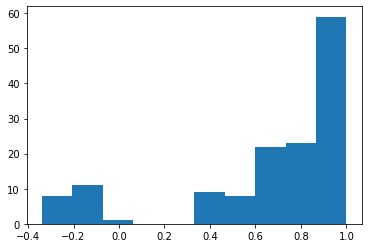

In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#x = np.array([i+1 for i in range(len(scorelist))])
#y = np.array(scorelist)
#plt.scatter(x, y)
plt.hist(scorelist)
plt.show()

## Random hasName head pairs

In [16]:
import random
import csv


def getRandomPairs(fin, ent2id, num=100):
    randompairlist = []
    headlist = []
    with open(fin) as f:
        csv_reader = csv.reader(f, delimiter=',')
        for row in csv_reader:
            headlist.append(row[-1].strip())
    headlist = list(set(headlist))
    while num > 0:
        random.shuffle(headlist)
        h1 = headlist[0]
        random.shuffle(headlist)
        h2 = headlist[0]
        if h1 in ent2id and h2 in ent2id:
            randompairlist.append((ent2id[h1], ent2id[h2]))
            num -= 1
        else:
            print(num)
    return randompairlist

In [17]:
# Random pairs
print('...generating data')

frandom = '../benchmarks/corefData/just_2_ent_win.txt'
randompairlist = getRandomPairs(frandom, ent2id)
simEvalData = randompairlist

print('...calculating similarity score')
scorelist, maxscore, minscore, avgscore, zerolist = sim_score(entid_embeddings_dict, simEvalData)
#print(sim_cte_bias)
#print('->', len(sim_cte_bias))

print('Source similarity of Identical target:')
print('\tavg:\t', avgscore, '\tSize of data:\t', len(simEvalData))
print('\tmax:\t', maxscore, '\tmin:\t', minscore, '\tNum of zero score pairs:\t', len(zerolist))

...generating data
...calculating similarity score
Source similarity of Identical target:
	avg:	 0.16641854312330057 	Size of data:	 100
	max:	 0.9973719113357232 	min:	 -0.4515629456315071 	Num of zero score pairs:	 0


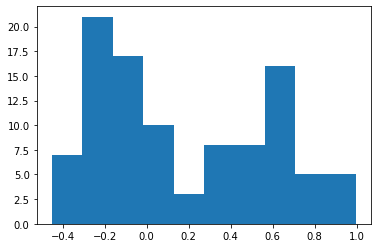

In [18]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#x = np.array([i+1 for i in range(len(scorelist))])
#y = np.array(scorelist)
#plt.scatter(x, y)
plt.hist(scorelist)
plt.show()